# Úkol č. 1 - vizualizace dat a web scraping (do 11. října)

  * V rámci tohoto úkolu musíte stáhnout dat z webu (tzv. _web scraping_, velmi základní) a následně data zpracovat a vizualizovat.
  * Cílem bude stáhnout data ze serveru https://www.psp.cz/sqw/hlasovani.sqw?o=8 týkající hlasování současné poslanecké sněmovny, uložit tato data v tabulkovém formátu a pak vymyslet vizualizace a zobrazení dat, které umožní orientaci v těchto datech a zvýrazní zajímavé informace a zobrazit přehledně časový vývoj různých veličin.
 
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

## Data

 * Měli byste stáhnout data ze všech hlasování současné poslanecké sněmovny (tj. od voleb v roce 2017) a to až na úroveň jednotlivých poslanců. 
 * Data by měla obsahovat i stručný popis toho, o jaké hlasování šlo.

## Pokyny k vypracování

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
  * Strojově stáhněte data a uložte je do vhodného formátu, který se Vám bude dále dobře zpracovávat. 
  * **I když nemusíte mít sněmovnu rádi, snažte se nezahltit server a mezi požadavky na stránku mějte alespoň vteřinu mezeru.**
  * V druhé části Vašeho Jupyter notebooku pracujte se staženými daty v souborech, které jsou výsledkem Vašeho stahovacího skriptu (aby opravující nemusel spouštět stahování z webu).
  * S využitím vybraných nástrojů zpracujte data a vymyslete vizualizace a grafy, aby bylo vidět následující:
    * Odchody a přeběhnutí poslanců mezi jednotlivými stranami.
    * Jakou mají jednotliví poslanci docházku (účast na hlasování) a jak jsou na tom s docházkou strany jako celek.
    * Jak často spolu jednotlivé strany hlasují ve shodě a jak často hlasují odlišně.
    * Jak jsou poslanci jednotlivých stran jednotní v hlasování (jak často hlasují stejně, kdo jsou největší rebelové).

**Další body zadání** za případné další body (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
  * Ve vizualizacích a grafech nějak zachyťte časový vývoj (např. jak se mění docházka, shoda mezi stranami atp.).
  * Najděte jednotlivé poslance, kteří se nejvíce shodují při svém hlasování či kteří mají co nejpodobnější účast na hlasování.
  * Zkuste rozlišit v datech důležitá hlasování a zpracujte vizualizace (také) pro ně.
  * Zkuste najít hlasování, kde poslanci hlasovali nejvíce jinak, než obvykle.
  
## Tipy a triky
  * Balíčky iportujte na začátku notebooku (příp. na začátku scrapovací a pak na začátku vizualizační části).
  * Využívejte markdown buňky (jako je ta, ve které je tento text) a naspisy, abyste usnadnily orientaci opravující(mu).
  * Pečlivě si vybírejte grafy a vizualizace, aby co nejlépe vyjádřily to, co vyjádřit chcete. Doporučuji projít si pro inspiraci alespoň galerie balíčků `matplotlib` a `seaborn`.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook (příp. doplněn skripty), ale i soubor(y) se staženými daty (ať opravující nemusí stahovat data).
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

## Steps:
1. Think
2. Download data
3. Parse data
4. Visualize
5. ??
6. Profit

## Download Data - nespúštať ak nechcete downloadovať, všetko je v priečinku ../data

In [2]:
import time
import requests
from bs4 import BeautifulSoup
from urllib3.util.retry import Retry
from requests.adapters import HTTPAdapter
import pandas as pd
import os
import html5lib
import matplotlib.pyplot as plt # takto se matplotlib standardně importuje
import matplotlib
import seaborn as sns

URL_PREFIX = 'https://www.psp.cz/sqw/'

#### Linky na jednotlive hlasovania

In [3]:
session = requests.Session()
session.headers.update({
    'User-Agent': 'Mozilla/5.0'
})
retries = Retry(total=5,
                backoff_factor=1,
                status_forcelist=[429, 500, 502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))

url = URL_PREFIX + 'hlasovani.sqw?o=8'
response = session.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table')
meetings = []
for tr in table.findAllNext('tr'):
    try:
        meetings.append(URL_PREFIX + tr.find('td').find('a')['href'])
    except:
        pass



#### Výsledky hlasovania a linky na jednotlive schodzky

In [ ]:
all_votings_results = pd.DataFrame
init_dfs_flag = True
meetings_vote_links = []
for mtg_url in meetings:
    response = requests.get(mtg_url)
    soup = BeautifulSoup(response.text, 'html.parser')
    vote_log = soup.find(id='main-content')
    table_url = URL_PREFIX + vote_log.find_next('a')['href']
    response = requests.get(table_url)
    # initiate table
    vote_links = {}
    if init_dfs_flag:
        all_votings_results = pd.read_html(response.text)[0]
        vote_links = links_from_vote(vote_links, response)

    for i in range(1, 100):
        if init_dfs_flag:
            init_dfs_flag = False
            continue
        page_url = table_url[:len(table_url) - 1] + str(i)
        response = requests.get(page_url)
        try:
            all_votings_results = all_votings_results.append(pd.read_html(response.text)[0])
        except Exception:
            break
        vote_links = {}
        soup = BeautifulSoup(response.text, 'html.parser')
        starting_point = soup.find('table')
        for link in starting_point.findAllNext('a'):
            if not str(link['href']).startswith('hlasy'):
                continue
            else:
                vote_links[link.text] = link['href']

    meetings_vote_links.append(vote_links)
all_votings_results['Výsledek'] = all_votings_results['Výsledek'].map({'Přijato': 1, "Zamítnuto": 0})

#### Vlastná classa, ktorá obsahuje jedno hlasovanie z 61 hlasovanie

In [4]:
class CProposal:
    def __init__(self, meeting_n=None, voting_n=None, url=None):
        if meeting_n is not None:
            self.meeting_n = meeting_n
            self.voting_n = voting_n
            response = requests.get(url)
            soup = BeautifulSoup(response.text, 'html.parser')
            results_tag = soup.find_all('ul', class_='results')
            self.df = pd.DataFrame(columns=['Name', 'Party', 'Vote', 'Mtg n.', 'Proposal n.'])
            for party in results_tag:
                party_name = str(party.previous_sibling.contents[0].next)[:-2]
                for member in party:
                    row = pd.Series(data={'Name': member.contents[2].string, "Party": party_name,
                                          "Vote": member.contents[0].string, 'Mtg n.': meeting_n, 'Proposal n.':voting_n})
                    self.df = self.df.append(row, ignore_index=True)

    def load(self, filename):
        dash_pos = str(filename).find('_')
        dot_pos = str(filename).find('.')
        self.meeting_n = int(str(filename)[:dash_pos])
        self.voting_n = int(str(filename)[dash_pos + 1:dot_pos])
        self.df = pd.read_csv('../data/' + filename)

    def save(self):
        members_file = '../data/' + str(self.meeting_n) + '_' + str(self.voting_n) + '.csv'
        self.df.to_csv(members_file, index=False)


#### Uložiť dataframes v csv podobe

In [ ]:
meeting_n = 0
for meeting in vote_links:
    meeting_n += 1
    for voting_number in meeting:
        url = URL_PREFIX + meeting[voting_number]
        proposal = CProposal(meeting_n, voting_number, url)
        proposal.save()

## Load from files

In [6]:
meetings = [[]] * 61
directory = '../data'
ban = []
for file in os.scandir(directory):
    if file.name in ban:
        continue
    proposal = CProposal()
    ban.append(proposal.load(file.name))
    meetings[proposal.meeting_n].append(proposal)

FileNotFoundError: [Errno 2] No such file or directory: '../data'

In [8]:
 df = pd.DataFrame(columns={'Name', 'Party', 'Vote', 'Mtg n.', 'Proposal n.'})
 for meeting in meetings:
    for proposal in meeting:
        df = df.append(proposal.df)

### Dochádzka poslancov

In [62]:
representatives_attendance = {}
total = 0
for representative in df['Name'].unique():
    votings = df.loc[df['Name'] == representative]
    votings = votings.reset_index()
    c = votings.groupby(['Vote']).size()
    representatives_attendance[representative] = c
    total = 0
    for vote in c:
        total += vote
    representatives_attendance[representative]['Total'] = total

Najlepšia dochádzka:


,0,A,M,N,Total,Z,Dochádzka
Věra Adámková,0.0,854.0,0.0,122.0,976.0,0.0,100.0
Petr Třešňák,0.0,793.0,0.0,122.0,976.0,61.0,100.0
Jan Lipavský,0.0,793.0,0.0,183.0,976.0,0.0,100.0
Tomáš Martínek,0.0,793.0,0.0,122.0,976.0,61.0,100.0
Jakub Michálek,0.0,793.0,0.0,183.0,976.0,0.0,100.0




Najhoršia dochádza:


,0,A,M,N,Total,Z,Dochádzka
Petr Dolínek,488.0,366.0,0.0,122.0,976.0,0.0,50.00
Karel Schwarzenberg,183.0,244.0,366.0,183.0,976.0,0.0,43.75
Milan Chovanec,427.0,122.0,122.0,0.0,976.0,305.0,43.75
Lubomír Zaorálek,671.0,305.0,0.0,0.0,976.0,0.0,31.25
Jiří Dolejš,366.0,244.0,305.0,0.0,976.0,61.0,31.25


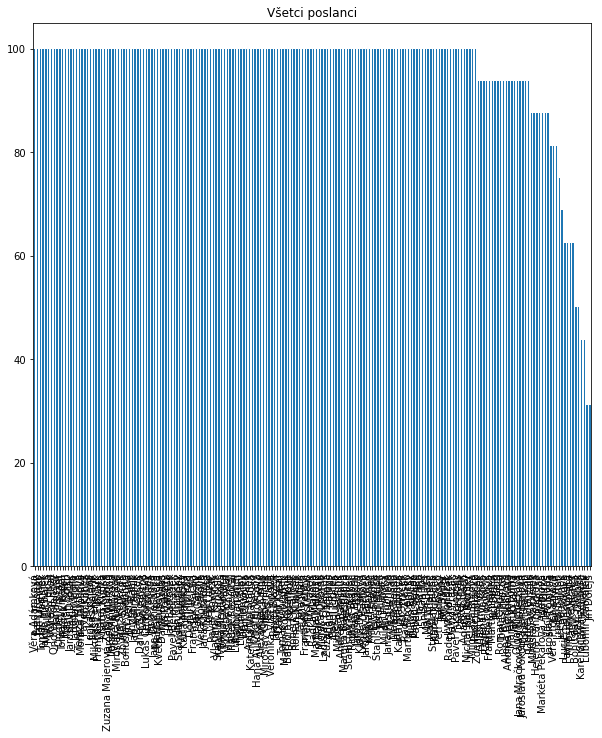

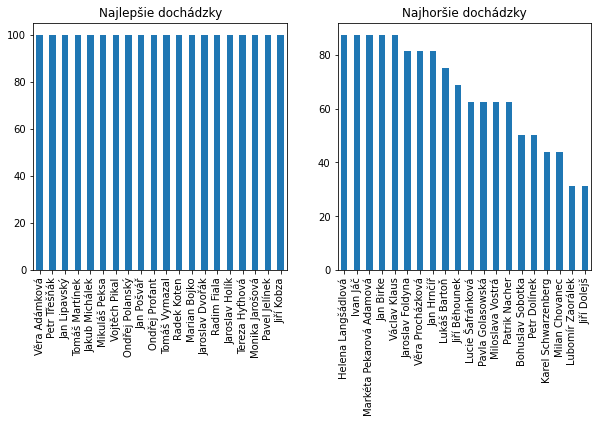

In [70]:
   
attendance_df = pd.DataFrame(representatives_attendance).T
attendance_df = attendance_df.fillna(0)
attendance_df['Dochádzka'] = (attendance_df['A'] + attendance_df['N'] + attendance_df['Z']) / attendance_df['Total'] * 100
attendance_df = attendance_df.sort_values(by=['Dochádzka'], ascending=False)
plt.figure(figsize=(10,10))
plt.title('Všetci poslanci')
attendance_df['Dochádzka'].plot.bar()
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Najlepšie dochádzky')
attendance_df.head(20)['Dochádzka'].plot.bar()
plt.subplot(222)
plt.title('Najhoršie dochádzky')
attendance_df.tail(20)['Dochádzka'].plot.bar()
print("Najlepšia dochádzka:")
display(attendance_df.head(5))
print('\n')
print("Najhoršia dochádza:")
display(attendance_df.tail(5))

## Dochádzka podľa strán

In [89]:
party_att = {}
for proposal in df['Proposal n.'].unique():
    proposals = df.loc[df['Proposal n.'] == proposal]
    proposals = proposals.reset_index()
    c = proposals.groupby(['Party']).size()
    party_att[proposal] = c
    total = 0
    for party in c:
        total += party
    party_att[proposal]['Total'] = total
   
part = pd.DataFrame(party_att).T
part = part.fillna(0)
display(part)

Party,ANO,KDU-ČSL,KSČM,ODS,Piráti,SPD,STAN,TOP09,ČSSD,Total
8,4758,610,915,1525,1342,1342,366,427,915,12200
15,4758,610,915,1525,1342,1342,366,427,915,12200
13,4758,610,915,1525,1342,1342,366,427,915,12200
9,4758,610,915,1525,1342,1342,366,427,915,12200
16,4758,610,915,1525,1342,1342,366,427,915,12200
12,4758,610,915,1525,1342,1342,366,427,915,12200
14,4758,610,915,1525,1342,1342,366,427,915,12200
10,4758,610,915,1525,1342,1342,366,427,915,12200
1,4758,610,915,1525,1342,1342,366,427,915,12200
11,4758,610,915,1525,1342,1342,366,427,915,12200
